# Image Classification with ```scikit-learn```

## Import packages

In [2]:
import os
import sys
sys.path.append(os.path.join(".."))

# Import teaching utils
import numpy as np
import utils.classifier_utils as clf_util

# Import sklearn metrics
from sklearn import metrics
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Fetch data

We're using something called the MNIST dataset, a very famous dataset in image classification. It even has it's own [Wikipedia page](https://en.wikipedia.org/wiki/MNIST_database)!

For this session, we're just fetching the data from a website called [OpenML](https://www.openml.org/), an open collection of datasets and experiments. I'd recommend digging around in there and seeing what kinds of datasets are available for experiments - there might be something for an exam project.

We load the data here using a function from ```scikit-learn``` which takes the data from OpenML and assigns it directly to two variables.

In [3]:
X, y = fetch_openml('mnist_784', 
                    version=1, 
                    parser="auto",
                    return_X_y=True)

Let's first check what the labels are in our data. This is what we're trying to predict.

In [4]:
sorted(set(y)) # the labels are numbers from 0-9

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Depending on the versions of ```pandas``` and ```sklearn``` that you're using, you may need to expressly convert these to ```numpy``` arrays.

In [5]:
X = np.array(X)
y = np.array(y)

__Predifine classes and number of classes__

We're going to start by making variables which contain the list of classes, and the total number of classes. This isn't strictly necessary, but we'll be using them later on in our notebook.

In [6]:
classes = sorted(set(y))
nclasses = len(classes)

**Question!** 

What does the data look like? What can you tell me about each individual image?

**Answer**

There are 70,000 images in total; 60,000 train images and 10,000 test images. 

y contains a list of length 70,000, containing the label for each of the images, i.e., labels from 0-9. 

X contains a 2D array of size 70,000x784. 784 is the number of pixels in each image lined up in a row. So all the 70,000 image's pixels

__Plot random sample__

I've created a util function called ```plot_sample()``` which simply plots a random sample of the data.

**Group task:** Go inspect the ```plot_sample()``` function - can you explain what it does and how it works?

(look more at this). The function draws random samples from each of the classes and plots them in a grid


def plot_sample(X, y, classes, samples_per_class):
    """
    Plots a grid of samples for each class
    
    data: the data to be plotted
    classes: list of all classes
    samples_per_class: number of samples to show
    """
    nclasses = len(classes)

    # The enumerate function includes the index and the value of the classes list.
    figure = plt.figure(figsize=(nclasses*2,(1+samples_per_class*2)))

    # for each value in classes
    for idx_cls, cls in enumerate(classes):
        # pick some at random to plot
        idxs = np.flatnonzero(y == cls) # returns the indices of the y array that are not zero

        idxs = np.random.choice(idxs, samples_per_class, replace=False) # generates a random sample from an array

        # plot on a grid for comparison
        for i, idx in enumerate(idxs):
            plt_idx = i * nclasses + idx_cls + 1
            p = plt.subplot(samples_per_class, nclasses, plt_idx);
            p = sns.heatmap(np.reshape(X[idx], (28,28)), cmap=plt.cm.gray, 
                            xticklabels=False, yticklabels=False, cbar=False)
            p = plt.axis('off')
    
    return None

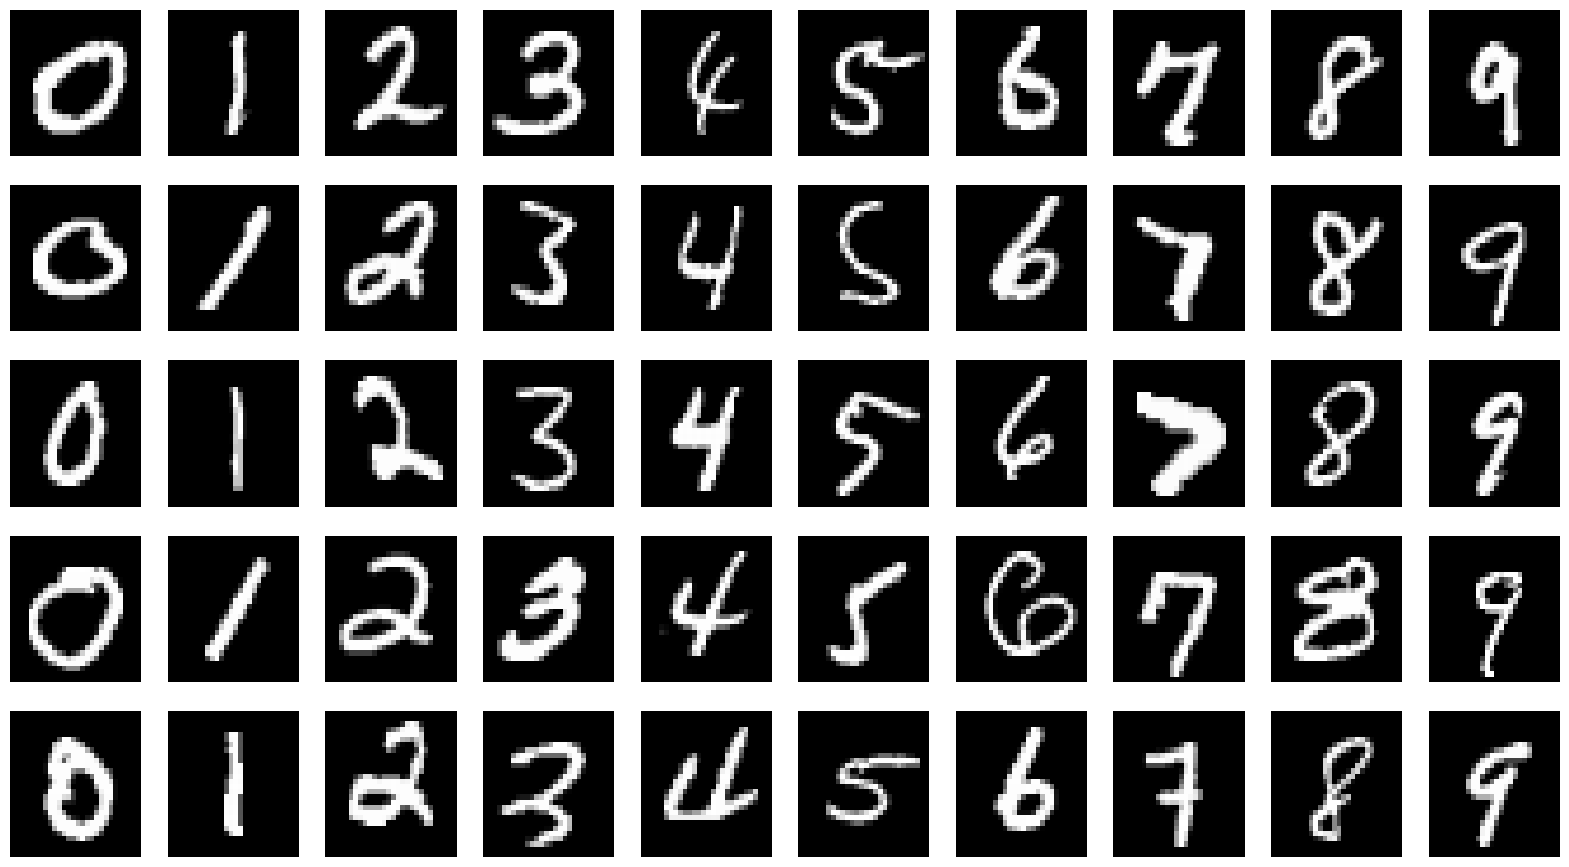

In [7]:
clf_util.plot_sample(X, y, classes, 5)

## Create training and test dataset

We then use our ```train_test_split()``` function to split the data into a training and a test set.

Notice that we're not defining this split in terms of percentages, but instead using whole numbers. We have 7500 training examples, and 2500 test examples.

**Group task:** What effect does it have if you make the training split larger or smaller? Test it!

**Answer**: For some reason, the accuracy, recall and F1 scores improve when doing a 50/50 split. However, this is not necessarily the same situation of one did k-fold cross validation instead, where the data is split in different folds for validation of the model

In [54]:
# (we need to use both out X's and Y's as the X is our data, and Y is the label/what must be predicted from the data)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42, # makes the results reproducible
                                                    train_size=7500, # defines the test and train sizes
                                                    test_size=2500)

As with our simple image search algorithm, it's a good idea to scale our data when working with images.

Previously, we saw how to do what was called ```MinMax`` scaling. A simpler approach - and often just as effective - is simple to divide by the maximum possible value.

In [30]:
#scaling the features
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0

## Train a logistic regression model

Next, I'm defining my Logistic Regression classifier. I've included a number of parameters here which we haven't yet looked at.

**Group task:** Check out the ```scikit-learn``` documentation for ```LogisticRegression()``` and read how each of the parameters here are defined. Can you understand what each of them do? Try changing some of them to see how it affects performance!

In [53]:
clf = LogisticRegression(tol=0.1, # a sort of parameter of when to stop the iteration.
                         solver='saga', # the algorithm to optimize to. Saga is supposedly good for large datasets.
                         multi_class='multinomial').fit(X_train_scaled, y_train) # multinomial as we have 10 outcomes

# fitting the logitic regression with the above parameters to the X and y train data. .fit is a method for logistic regression classes in scikit-learn that fits the model, i.e., finds the parameters (beta values)
# "learning" from the X-train and y-train data

When our model is finished learning, we have a collection of weights that the model has learned.

**Group task:** Before running the following cell, try to figure out what shape this matrix will be.

I would guess that it would be of size 784

In [32]:
#to check the shape of the coefficient (weights) matrix
clf.coef_.shape

(10, 784)

In [33]:
hej = clf.coef_

## Interpreting the coefficients

We can plot the coefficients for our model, showing which 'features' are most informative when it comes to predicting each class

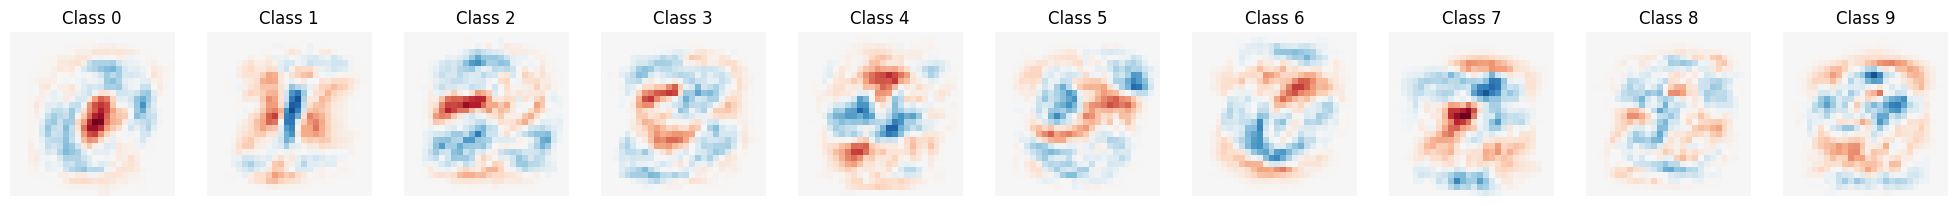

In [34]:
clf_util.plot_coefs(clf.coef_, nclasses)

## Individual predictions

We can then use this model to predict the class of an individual data point.

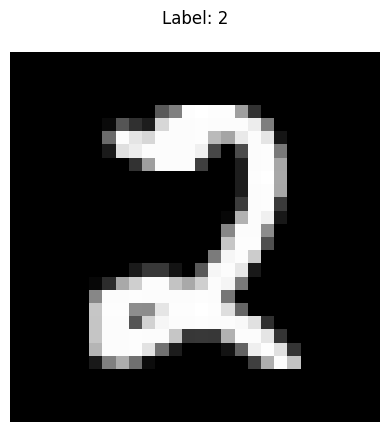

In [35]:
clf_util.plot_individual(X_test_scaled, 
                         y_test, 
                         50)

We can compute the conditional probability for each class and then plot the probability distribution.

## Show the distribution of probabilities

I think that this is class 2


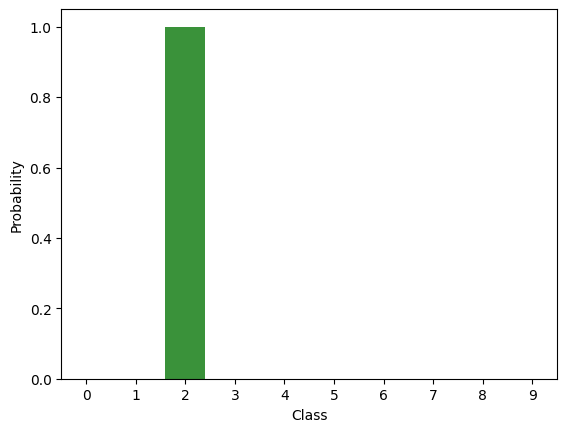

In [36]:
clf_util.plot_probs(X_test_scaled, 50, clf, classes)

We can find the class with the highest probability. 

If this matches the actual label for the first test sample, then our prediction is correct.

## Accuracy

We can calculate predictions for all data the scaled test data.

In [37]:
y_pred = clf.predict(X_test_scaled)

We then calculate metrics for accuracy based on comparing the predicted labels with the actual labels.

In [38]:
#method 2
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9066


In [39]:
cm = metrics.classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       490
           1       0.92      0.98      0.95       551
           2       0.88      0.86      0.87       483
           3       0.91      0.85      0.88       556
           4       0.88      0.93      0.91       433
           5       0.88      0.87      0.87       476
           6       0.93      0.94      0.94       490
           7       0.93      0.92      0.92       515
           8       0.86      0.84      0.85       489
           9       0.92      0.90      0.91       517

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



This can be visualised using a confusion matrix

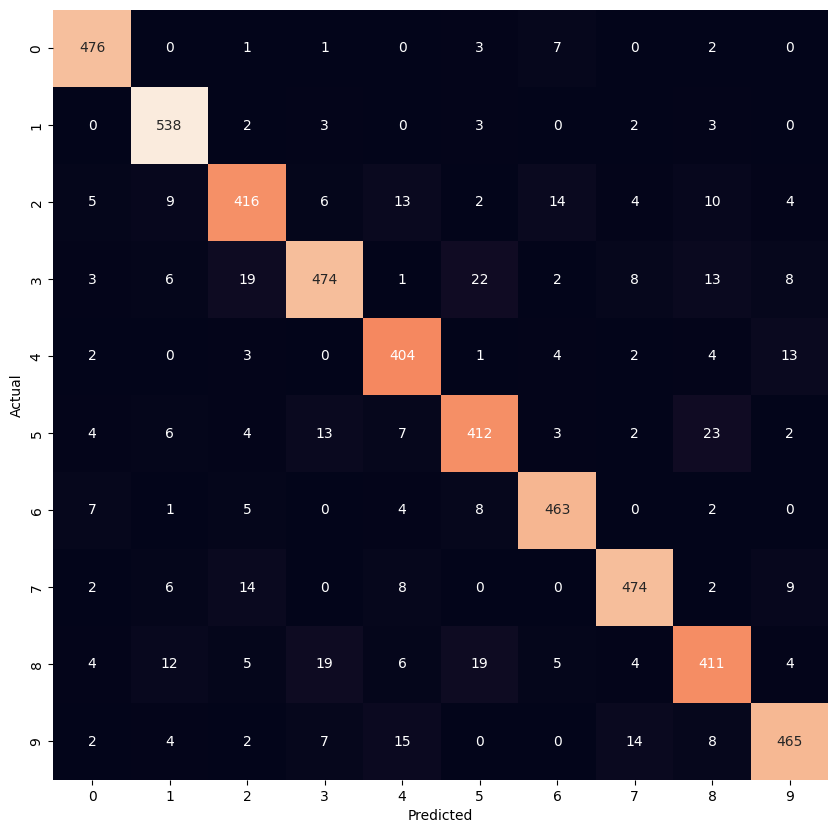

In [40]:
clf_util.plot_cm(y_test, y_pred, normalized=False)

We can also normalize the confusion matrix to show percentages instead of raw values

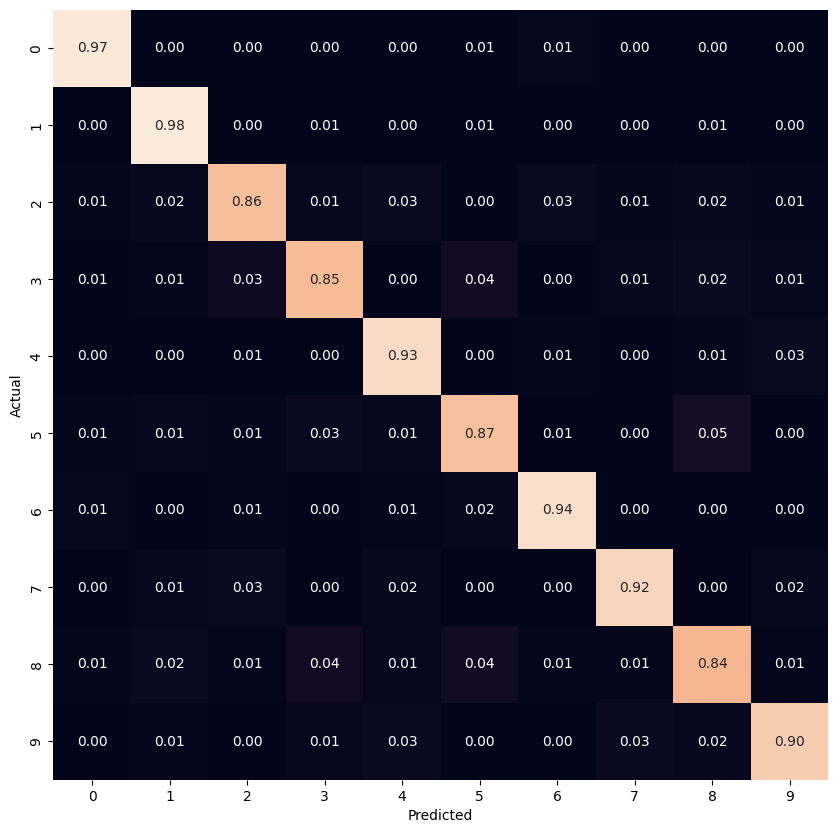

In [41]:
clf_util.plot_cm(y_test, y_pred, normalized=True)

## Test on new data

In [42]:
import cv2
import matplotlib.pyplot as plt
from utils.imutils import jimshow, jimshow_channel

Question: Where should scaling come in this pipeline?  Does it matter at which point you do the scaling?

Answer: probably before fitting the model, as a model will be fit faster on scaled images than on non-scaled. 

In [48]:
path = os.path.join("..", "data", "img", "four_drawing.png")
test_image = cv2.imread(path)
test_image_scaled = test_image/255.0

Use bitwise not to invert regular grayscale

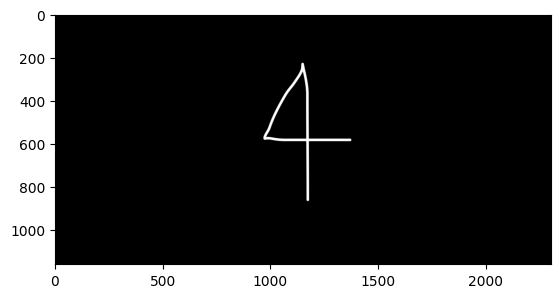

In [52]:
gray = cv2.bitwise_not(cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY))
plt.imshow(gray, cmap=plt.cm.gray)

Resize down to 28x28 image

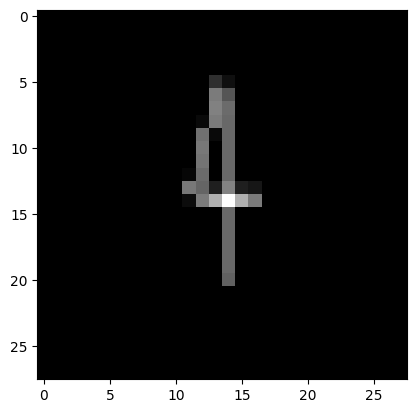

In [50]:
compressed = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_AREA)
plt.imshow(compressed, cmap=plt.cm.gray)

### Qualitative evaluation

I think that this is class 1


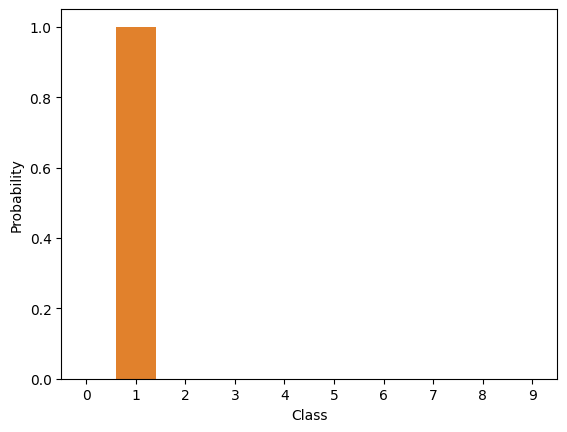

In [46]:
clf_util.predict_unseen(compressed, clf, classes)

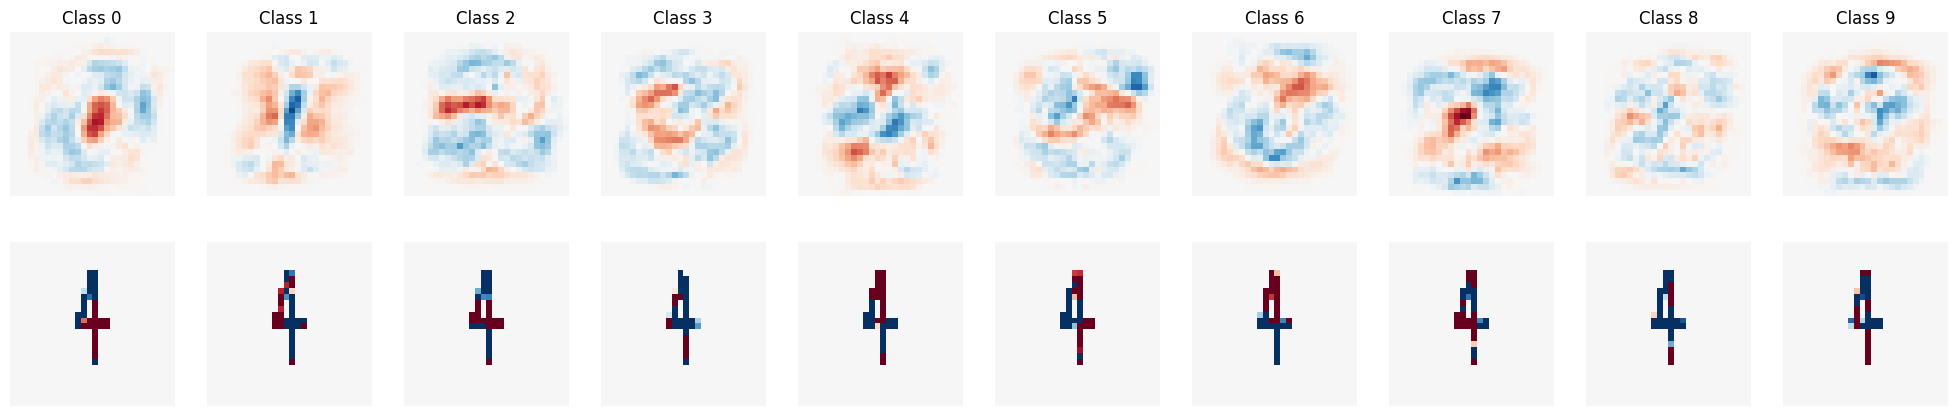

In [28]:
clf_util.prediction_coefficients(compressed, clf, classes)

## Tasks

- Go back to the start of this notebook and work through again in groups. Stop at the point where it says "Group Tasks" and work on this in groups of 3 or 4. 
  - If you get stuck, you can skip ahead to the next one, but try to cover all of them.
- Try the same thing using the ```MLPCLassifier()``` from ```scikit-learn```
  - If someone from your group wasn't there, explain to them how it works!